In a [previous post](https://danvatterott.com/blog/2019/04/19/are-some-mlb-players-more-likely-to-hit-into-errors-than-others/), I described how to download and clean data for understanding how likely a baseball player was to hit into an error given that they hit the ball into play.

This analysis will statisically demonstrate that some players are more likely to hit into errors than others.

Errors are uncommon, so players hit into errors very infrequently. Estimating the liklihood of an infrequent event is hard and requires lots of data. To generate as much data as possible, I wrote a bash script that will download data for all players between 1970 and 2018.

Having many years of data enables me to use data from multiple years for each player. This gives me more data to use when estimating how likely a particular player is to hit into an error.

In [1]:
# %%bash

# for i in {1970..2018}; do
#     echo "YEAR: $i"
#     ../scripts/get_data.sh ${i};
# done

# find processed_data/* -type f -name 'errors_bip.out' | \
#     xargs awk '{print $0", "FILENAME}' | \
#     sed s1processed_data/11g1 | \
#     sed s1/errors_bip.out11g1 > \
#         processed_data/all_errors_bip.out

Looking at the data we see 5 columns: playerid, playername, errors hit into, balls hit into play (BIP), and year. The file does not have a header.

In [2]:
%%bash
head ../processed_data/all_errors_bip.out

aaroh101, Hank Aaron, 8, 453, 1970
aarot101, Tommie Aaron, 0, 53, 1970
abert101, Ted Abernathy, 0, 10, 1970
adaij101, Jerry Adair, 0, 24, 1970
ageet101, Tommie Agee, 12, 480, 1970
akerj102, Jack Aker, 0, 10, 1970
alcal101, Luis Alcaraz, 1, 107, 1970
alleb105, Bernie Allen, 1, 240, 1970
alled101, Dick Allen, 4, 341, 1970
alleg101, Gene Alley, 6, 356, 1970


I can load the data into pandas using the following command.

In [3]:
import pandas as pd

DF = pd.read_csv('../processed_data/all_errors_bip.out',
                 header=None,
                 names=['playerid', 'player_name', 'errors', 'bip', 'year'])

In [4]:
DF.head()

,playerid,player_name,errors,bip,year
0,aaroh101,Hank Aaron,8,453,1970
1,aarot101,Tommie Aaron,0,53,1970
2,abert101,Ted Abernathy,0,10,1970
3,adaij101,Jerry Adair,0,24,1970
4,ageet101,Tommie Agee,12,480,1970


In [5]:
len(DF)

38870

I have almost 39,000 year, player combinations.... a good amount of data to play with.

While playing with the data, I noticed that players used to hit into more errors frequently than they do now. Let's see how the probability that a player hits into an error changes across the years.

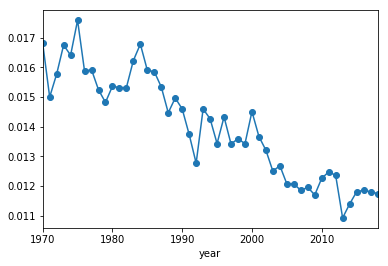

In [6]:
%matplotlib inline

YEAR_DF = (DF
           .groupby("year")
           .agg({
               "errors": "sum",
               "bip": "sum"
           })
           .assign(prop_error=lambda x: x["errors"] / x["bip"])
          )

YEAR_DF["prop_error"].plot(style="o-");

Interestingly, the proportion of errors per BIP [has been dropping over time](https://www.pinstripealley.com/2013/8/16/4623050/mlb-errors-trends-statistics). I am not sure if this is a conscious effort by MLB score keepers or improved fielding (but I suspect it's the score keepers). It looks like this drop in errors per BIP leveled off around 2015. Zooming in.

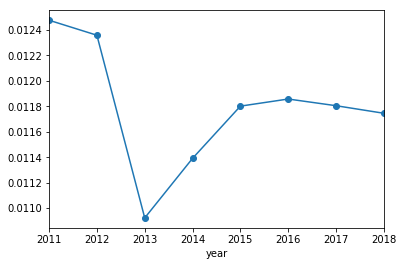

In [7]:
YEAR_DF[YEAR_DF.index > 2010]["prop_error"].plot(style="o-");

I explore this statistically in [another notebook](https://github.com/dvatterott/mlb_errors).

Because I don't want the year to confound our analyses I remove all data before 2015.

In [8]:
DF = DF[DF["year"] >= 2015]

In [9]:
len(DF)

3591

This leaves me with 3500 year, player combinations.

We collected data from multiple years so that we can combine data across years.

In [10]:
GROUPED_DF = DF.groupby(["playerid", "player_name"]).agg({"errors": "sum", "bip": "sum"}).reset_index()

In [11]:
GROUPED_DF.describe()

,errors,bip
count,1552.000000,1552.000000
mean,3.835052,324.950387
std,6.073256,494.688755
min,0.000000,1.000000
25%,0.000000,7.000000
50%,1.000000,69.000000
75%,5.000000,437.000000
max,37.000000,2102.000000


I want an idea for how likely players are to hit into errors.

In [12]:
TOTALS = GROUPED_DF.agg({"errors": "sum", "bip": "sum"})
ERROR_RATE = TOTALS["errors"] / TOTALS["bip"]
ERROR_RATE

0.011801960251664112

Again, errors are very rare, so I want know how many "trials" (BIP) I need to get a reasonable estimate for how likely each player is to hit into an error.

A good rule of thumb is each player should have hit into at least 5 errors. I can estimate how many balls in play that would require on average.

In [13]:
5. /ERROR_RATE

423.65843413978496

Looks like I should require at least 425 BIP for each player. Just to be on the safe side, I will round this to 500.

In [14]:
GROUPED_DF = GROUPED_DF[GROUPED_DF["bip"] > 500]

In [15]:
GROUPED_DF = GROUPED_DF.reset_index(drop=True)

In [16]:
GROUPED_DF.head()

,playerid,player_name,errors,bip
0,abrej003,Jose Abreu,20,1864
1,adamm002,Matt Adams,6,834
2,adrie001,Ehire Adrianza,2,533
3,aguij001,Jesus Aguilar,2,551
4,ahmen001,Nick Ahmed,12,1101


In [17]:
GROUPED_DF.describe()

,errors,bip
count,354.000000,354.000000
mean,12.991525,1129.059322
std,6.447648,428.485467
min,1.000000,503.000000
25%,8.000000,747.250000
50%,12.000000,1112.000000
75%,17.000000,1475.750000
max,37.000000,2102.000000


I've identified 354 players in the last year who have enough BIP for us to estimate how frequently they hit into errors. 

Below, I plot how the liklihood of hitting into errors is distributed.

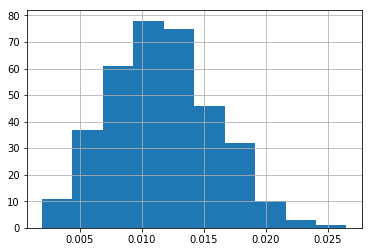

In [18]:
%matplotlib inline

GROUPED_DF["prop_error"] = GROUPED_DF["errors"] / GROUPED_DF["bip"]
GROUPED_DF["prop_error"].hist();

It looks relatively normal. Now the question is whether someone who has hit into errors in 2% of their BIP is more likely to hit into errors than someone who has only hit into errors 0.5% of their BIP (or is this all just random variation).

To try and estimate this, I treat each BIP as a bernoulli trial. Hitting into an error is a "success". I can then use a binomial distribution to model the number of "successes" per trial (BIP). I would like to know if different players are more or less likely to hit into errors. To do this, I model each player as having their own binomial distribution and the question is whether these *p* (the probability of success) differs across players. 

The traditional ways to answer this question would be to use a [chi square contingency test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy.stats.chi2_contingency) but this would just tell us whether players differ at all and not which players differ.

The traditional way to identify which players differ is to do pairwise comparisons of players, but this results in TONS of comparisons making a [false positives all but certain](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) when doing many comparisons.

Another option is to harness bayesian statistics and build a [hierarchical beta-binomial model](http://sl8r000.github.io/ab_testing_statistics/use_a_hierarchical_model/). The intuition here is that each player's probability of hitting into an error is drawn from a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). We want to know whether these beta distributions are different. We then assume we can best estimate a player's beta distribution by using that a particular players data AND data from all players. 

The model is built so that as we accrue data about a particular player, we will trust that data more and more, relying on the data from all players less and less. This is called partial pooling. [Here's](https://dsaber.com/2016/08/27/analyze-your-experiment-with-a-multilevel-logistic-regression-using-pymc3%E2%80%8B/) a useful explaination.

I largely based this analysis on [this](https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html) tutorial. Reference for tutorial for an explaination of how I choose my priors. I ended up using a greater lambda value (because the model sampled better) in the Exponential prior, and while this did lead to more extreme estimates of error likihood, it didn't change the basic story.

In [19]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt

with pm.Model() as model:
 
    phi = pm.Uniform('phi', lower=0.0, upper=1.0)
    
    kappa_log = pm.Exponential('kappa_log', lam=25.)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    rates = pm.Beta('rates', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=len(GROUPED_DF))

    trials = np.array(GROUPED_DF["bip"])
    successes = np.array(GROUPED_DF["errors"])
 
    obs = pm.Binomial('observed_values', trials, rates, observed=successes)
    trace = pm.sample(2000, tune=1000, chains=2, cores=2, nuts_kwargs={'target_accept': .95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rates, kappa_log, phi]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:47<00:00, 28.06draws/s] 


Check wether the model converged.

In [20]:
max(np.max(score) for score in pm.gelman_rubin(trace).values())

1.0022635936332533

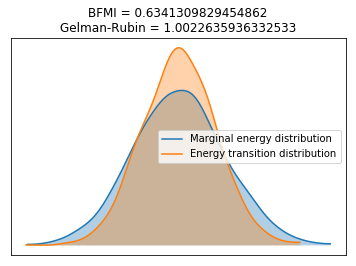

In [21]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())
(pm.energyplot(trace, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

The most challenging parameter to fit is kappa which accounts for the variance in the liklihood to hit into an error. I take a look at it to make sure things look as expected.

In [22]:
pm.summary(trace, varnames=["kappa"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
kappa,927.587178,141.027597,4.373954,657.066554,1201.922608,980.288914,1.000013


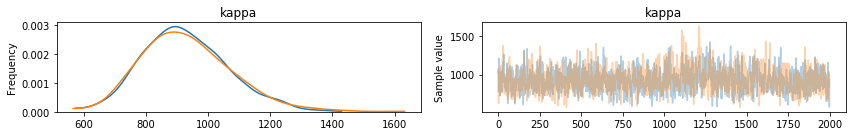

In [23]:
pm.traceplot(trace, varnames=['kappa']);

We can also look at *phi* the estimated global liklihood to hit into an error.

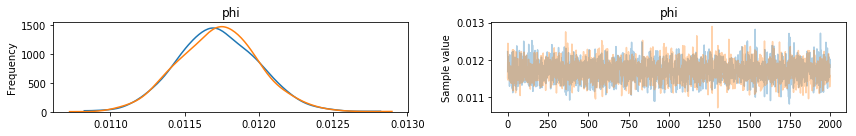

In [24]:
pm.traceplot(trace, varnames=['phi']);

Finally, we can lookat how all players vary in their liklihood to hit into an error.

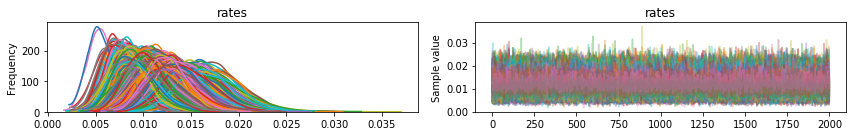

In [25]:
pm.traceplot(trace, varnames=['rates']);

Obviously, the amove plot is a lot to look at it, so let's order players by how likely the model believes they are to hit in an error.

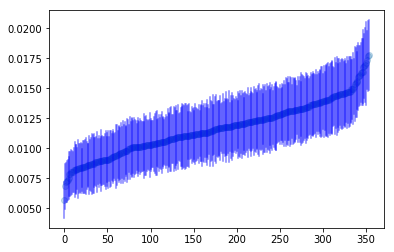

In [26]:
from matplotlib import pyplot as plt

rate_means = trace['rates', 1000:].mean(axis=0)
rate_se = trace['rates', 1000:].std(axis=0)

mean_se = [(x, y, i) for i, x, y in zip(GROUPED_DF.index, rate_means, rate_se)]
sorted_means_se = sorted(mean_se, key=lambda x: x[0])
sorted_means = [x[0] for x in sorted_means_se]
sorted_se = [x[1] for x in sorted_means_se]

x = np.arange(len(sorted_means))

plt.plot(x, sorted_means, 'o', alpha=0.25);

for x_val, m, se in zip(x, sorted_means, sorted_se):
    plt.plot([x_val, x_val], [m-se, m+se], 'b-', alpha=0.5)

The ten players who are most likely to hit into an error.

In [27]:
estimated_mean = pm.summary(trace, varnames=["rates"]).iloc[[x[2] for x in sorted_means_se[-10:]]]["mean"]

GROUPED_DF.loc[[x[2] for x in sorted_means_se[-10:]], :].assign(estimated_mean=estimated_mean.values).iloc[::-1]

,playerid,player_name,errors,bip,prop_error,estimated_mean
71,corrc001,Carlos Correa,30,1368,0.021930,0.017838
227,myerw001,Wil Myers,27,1214,0.022241,0.017724
15,andre001,Elvis Andrus,37,1825,0.020274,0.017420
258,plawk001,Kevin Plawecki,14,528,0.026515,0.017200
285,rojam002,Miguel Rojas,21,952,0.022059,0.017001
118,garca003,Avisail Garcia,28,1371,0.020423,0.016920
244,pench001,Hunter Pence,22,1026,0.021442,0.016875
20,baezj001,Javier Baez,23,1129,0.020372,0.016443
335,turnt001,Trea Turner,23,1140,0.020175,0.016372
50,cainl001,Lorenzo Cain,32,1695,0.018879,0.016332


We can also look at the 10 players who are least likely to hit in an error. 

In [28]:
estimated_mean = pm.summary(trace, varnames=["rates"]).iloc[[x[2] for x in sorted_means_se[:10]]]["mean"]

GROUPED_DF.loc[[x[2] for x in sorted_means_se[:10]], :].assign(estimated_mean=estimated_mean.values)

,playerid,player_name,errors,bip,prop_error,estimated_mean
226,murpd006,Daniel Murphy,4,1680,0.002381,0.005670
223,morrl001,Logan Morrison,4,1241,0.003223,0.006832
343,vottj001,Joey Votto,8,1724,0.004640,0.007112
239,panij002,Joe Panik,7,1542,0.004540,0.007245
51,calhk001,Kole Calhoun,9,1735,0.005187,0.007413
55,carpm002,Matt Carpenter,8,1566,0.005109,0.007534
142,hamib001,Billy Hamilton,8,1476,0.005420,0.007822
289,rosae001,Eddie Rosario,8,1470,0.005442,0.007855
275,renda001,Anthony Rendon,9,1564,0.005754,0.007966
8,alony001,Yonder Alonso,8,1440,0.005556,0.008011


Looking at this list, I can't help but wonder if what causes these players to be more or less likely to hit into an error is how the score keeper feels about the player. This looks more like a list of fan favorites (e.g., Daniel Murphy, Chris Carpenter, Votto, Rizzo) than players who are particularly unlikley to hit into an error. More or less I am thinking the score keeper WANT to award these players hits. 

Think about it as a smaller version of the "superstar" call in basketball where the NBA referees pick different players to be more or less talented. 

We can assign a probability to how likely Correa is to be better at hitting into errors than Daniel Murphy.

In [29]:
np.mean(trace['rates', 1000:][:, 71] <= trace['rates', 1000:][:, 226])

0.0

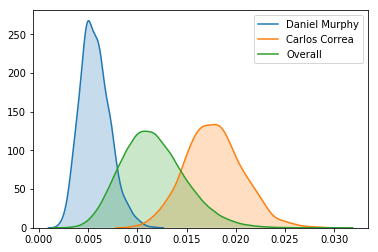

In [30]:
import seaborn as sns

sns.kdeplot(trace['rates', 1000:][:, 226], shade=True, label="Daniel Murphy");
sns.kdeplot(trace['rates', 1000:][:, 71], shade=True, label="Carlos Correa");
sns.kdeplot(trace['rates', 1000:].flatten(), shade=True, label="Overall");

We can also look exclusively at how the ten most likely and 10 least likely players to hit into an error compare.

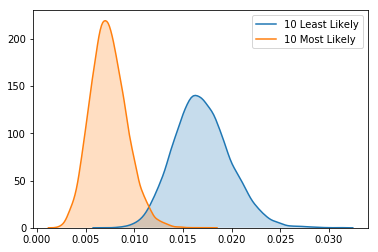

In [31]:
sns.kdeplot(trace['rates', 1000:][:, [x[2] for x in sorted_means_se[-10:]]].flatten(), shade=True, label="10 Least Likely");
sns.kdeplot(trace['rates', 1000:][:, [x[2] for x in sorted_means_se[:10]]].flatten(), shade=True, label="10 Most Likely");